# Building a Simple Agent Graph and Managing States

## Learning Objectives
By the end of this notebook, you will be able to:
1. **Understand LangGraph fundamentals** - Learn the core building blocks: State, Nodes, and Edges
2. **Define State schemas** - Create custom state structures using Python's TypedDict
3. **Build simple graphs** - Connect nodes with edges to create processing pipelines
4. **Master state management** - Understand how state flows through the graph and gets updated
5. **Use reducer functions** - Learn how to append to state instead of overwriting it

## What is LangGraph?
LangGraph is a library for building **stateful, multi-actor applications** with LLMs. It extends LangChain by providing:
- **Graph-based orchestration** - Define workflows as directed graphs
- **Built-in state management** - Automatically track and update state across nodes
- **Cyclic workflows** - Support for loops and conditional branching
- **Persistence** - Save and resume graph execution

## Key Concepts
| Concept | Description |
|---------|-------------|
| **State** | Shared data structure that flows through the graph |
| **Node** | A Python function that processes and updates the state |
| **Edge** | Connection between nodes defining execution order |
| **Reducer** | Function that determines how state updates are merged |

In this hands-on demo we will understand how states work in an agentic graph and also how to build a simple agentic graph just like the one shown below.

![](https://i.imgur.com/ILcvB2y.png)

## Install Dependencies

In [1]:
# !pip install -qq langchain==0.3.14
# !pip install -qq langgraph==0.2.66

## Step 1: Define the State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.

### What is State?
The **State** is the central data structure that:
- Acts as the **shared memory** across all nodes in the graph
- Gets **passed to every node** as input
- Gets **updated by nodes** as they execute
- Serves as the **input/output schema** for the entire graph

### Why TypedDict?
We use Python's `TypedDict` because:
- Provides **type hints** for better code clarity and IDE support
- Ensures **consistent structure** across all nodes
- Makes the state schema **explicit and documented**

```
┌─────────────────────────────────────────────────────┐
│                     STATE                           │
│  ┌─────────────────────────────────────────────┐   │
│  │  messages: str   (or list, dict, etc.)      │   │
│  └─────────────────────────────────────────────┘   │
│                        ↓                            │
│              Passed to all nodes                    │
└─────────────────────────────────────────────────────┘
```

The State schema serves as the input schema for all Nodes and Edges in the graph. This is basically the schema of the shared context or data messages passes throughout the graph across all the nodes and edges.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [2]:
# ============================================================================
# DEFINING THE STATE SCHEMA
# ============================================================================
# TypedDict allows us to define a dictionary with specific key types
# This creates a blueprint for our state structure

from typing_extensions import TypedDict

class State(TypedDict):
    """
    State Schema for our simple graph.
    
    Attributes:
        messages (str): A string field to hold messages passed through the graph.
                       Each node can read and update this field.
    
    Note: By default, when a node returns a new value for 'messages',
          it will OVERWRITE the previous value (not append to it).
    """
    messages: str

## Step 2: Define Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions where we implement some custom logic, call some tools, LLMs etc.

### What are Nodes?
Nodes are the **workhorses** of your graph - they:
- Are **regular Python functions** that take state as input
- Can perform **any operation**: call LLMs, APIs, databases, tools, etc.
- **Return updated state** values to modify the shared state
- Execute in the order defined by edges

### Node Function Signature
```python
def my_node(state: State) -> dict:
    # 1. Read from state
    current_value = state['key']
    
    # 2. Do some processing
    new_value = process(current_value)
    
    # 3. Return state updates (partial update is allowed)
    return {"key": new_value}
```

### Key Points:
- The first positional argument is **always the state**
- Nodes can access any state key: `state['messages']`
- Nodes return a **dictionary** with the keys they want to update
- By default, returned values **overwrite** existing state values

> **Important**: By default, the new value returned by each node [will overwrite](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value. We will show shortly how to **append** to state instead of overwriting.

In [3]:
# ============================================================================
# DEFINING A NODE FUNCTION
# ============================================================================
# A node is just a Python function that:
# 1. Receives the current state as input
# 2. Performs some processing
# 3. Returns a dictionary with state updates

def node_1(state: State) -> State:
    """
    A simple node that processes the state and returns an updated message.
    
    Args:
        state: The current graph state containing all shared data
        
    Returns:
        dict: Updated state values - here we update the 'messages' key
        
    Note: 
        - We read from state['messages'] to access current value
        - We return {"messages": "..."} to UPDATE the state
        - This OVERWRITES the previous messages value (default behavior)
    """
    print("---Node 1---")
    current_message = state['messages']  # Read current state
    print(f"Received input: {current_message}")
    
    # Return new state - this will OVERWRITE the 'messages' field
    return {"messages": "Hello this is node 1"}

## Step 3: Define Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes and define the **execution flow** of your graph.

### Types of Edges in LangGraph

| Edge Type | Description | Use Case |
|-----------|-------------|----------|
| **Normal Edge** | Always goes from Node A to Node B | Sequential processing |
| **Conditional Edge** | Chooses next node based on logic | Decision making, routing |
| **Entry Edge** | Connects START to first node | Graph entry point |
| **Exit Edge** | Connects last node to END | Graph termination |

### Special Nodes: START and END
- `START`: A virtual node representing the **entry point** of the graph
- `END`: A virtual node representing the **exit point** of the graph

```
START ──────► node_1 ──────► node_2 ──────► END
       edge         edge           edge
```

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

## Step 4: Build the Graph

Now we'll assemble everything together:
1. **Create a StateGraph** - Initialize with our State schema
2. **Add nodes** - Register our node functions
3. **Add edges** - Connect nodes to define flow
4. **Compile** - Convert to executable graph

### Graph Building Pattern
```python
# 1. Initialize builder with State schema
builder = StateGraph(State)

# 2. Add nodes (name, function)
builder.add_node("node_name", node_function)

# 3. Add edges to define flow
builder.add_edge(START, "node_name")  # Entry point
builder.add_edge("node_name", END)     # Exit point

# 4. Compile to get executable graph
graph = builder.compile()
```

Graph Structure:


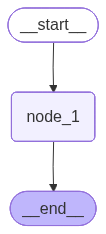

In [4]:
# ============================================================================
# BUILDING THE GRAPH
# ============================================================================
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# -----------------------------------------------------------------------------
# Step 1: Initialize the StateGraph with our State schema
# The StateGraph is our "builder" that we use to construct the graph
# -----------------------------------------------------------------------------
builder = StateGraph(State)

# -----------------------------------------------------------------------------
# Step 2: Add nodes to the graph
# add_node(name: str, function: callable)
# - 'name' is the unique identifier for this node in the graph
# - 'function' is the Python function that will be executed
# -----------------------------------------------------------------------------
builder.add_node("node_1", node_1)

# -----------------------------------------------------------------------------
# Step 3: Define the execution flow with edges
# - START is a special node representing the graph entry point
# - END is a special node representing the graph exit point
# -----------------------------------------------------------------------------
builder.add_edge(START, "node_1")  # START → node_1 (entry)
builder.add_edge("node_1", END)     # node_1 → END (exit)

# -----------------------------------------------------------------------------
# Step 4: Compile the graph
# This converts the builder into an executable graph object
# The compiled graph can be invoked with input data
# -----------------------------------------------------------------------------
graph = builder.compile()

# -----------------------------------------------------------------------------
# Visualize the graph structure
# LangGraph provides built-in visualization using Mermaid diagrams
# -----------------------------------------------------------------------------
print("Graph Structure:")
display(Image(graph.get_graph().draw_mermaid_png()))

## Step 5: Test the Graph

Now let's test our graph by invoking it with an initial state.

### Invoking the Graph
- `graph.invoke(initial_state)` - Runs the graph synchronously
- Returns the **final state** after all nodes have executed
- The initial state must match our State schema

In [5]:
# ============================================================================
# INVOKING THE GRAPH
# ============================================================================
# graph.invoke() runs the graph with the provided initial state
# It returns the final state after all nodes have executed

initial_state = {"messages": "Hi, how are you?."}

print(f"Input state: {initial_state}")
print("-" * 50)

# Run the graph - this will:
# 1. Start at START
# 2. Execute node_1 with the input state
# 3. Return the final state (which node_1 updated)
final_state = graph.invoke(initial_state)

print("-" * 50)
print(f"Final state: {final_state}")

Input state: {'messages': 'Hi, how are you?.'}
--------------------------------------------------
---Node 1---
Received input: Hi, how are you?.
--------------------------------------------------
Final state: {'messages': 'Hello this is node 1'}


---

## Part 2: Graph with Custom State Schema

So far we've used a simple state with just one field. Let's create a **more complex state** with multiple fields of different types.

### Why Custom State Schemas?
In real-world applications, you need to track multiple pieces of information:
- **Conversation history** (list of messages)
- **User context** (user ID, preferences)
- **Processing flags** (counters, status)
- **Intermediate results** (computed values)

You can define your own state schema with multiple fields and manipulate them inside the graph as shown below.

In [6]:
# ============================================================================
# CUSTOM STATE SCHEMA WITH MULTIPLE FIELDS
# ============================================================================
from langgraph.graph import StateGraph, START, END

# -----------------------------------------------------------------------------
# Define a more complex state with multiple fields
# Each field can have its own type (str, int, list, dict, etc.)
# -----------------------------------------------------------------------------
class State(TypedDict):
    """
    Custom State with multiple fields.
    
    Attributes:
        data (str): Text data that will be processed
        counter (int): A numeric counter to track processing steps
    """
    data: str
    counter: int

# Initialize the StateGraph with our custom state schema
graph_builder = StateGraph(State)

# -----------------------------------------------------------------------------
# Define a node that manipulates multiple state fields
# This demonstrates how nodes can read and update multiple fields
# -----------------------------------------------------------------------------
def process_state(state: State) -> State:
    """
    Process node that:
    1. Reads both 'data' and 'counter' from state
    2. Transforms 'data' to uppercase
    3. Increments 'counter' by 1
    4. Returns updated values for both fields
    """
    # Read current state values
    current_data = state['data']
    current_counter = state['counter']
    
    print(f"Current data: '{current_data}', Counter: {current_counter}")
    
    # Process and return updated state
    # Note: We're updating BOTH fields in a single return
    return {
        "data": current_data.upper(),      # Transform to uppercase
        "counter": current_counter + 1      # Increment counter
    }

# Build the graph
graph_builder.add_node("process_state", process_state)
graph_builder.add_edge(START, "process_state")
graph_builder.add_edge("process_state", END)

# Compile the graph
graph = graph_builder.compile()

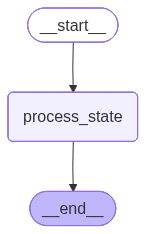

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# ============================================================================
# EXECUTE THE GRAPH WITH CUSTOM STATE
# ============================================================================

# Define initial state with values for ALL fields in our schema
initial_state = {"data": "hello world", "counter": 0}

print("=" * 50)
print(f"Initial State: {initial_state}")
print("=" * 50)

# Invoke the graph
result = graph.invoke(initial_state)

# Examine the results
print("=" * 50)
print(f"Final State: {result}")
print("=" * 50)
print(f"\nObservations:")
print(f"  - 'data' was transformed: 'hello world' → '{result['data']}'")
print(f"  - 'counter' was incremented: 0 → {result['counter']}")

Initial State: {'data': 'hello world', 'counter': 0}
Current data: 'hello world', Counter: 0
Final State: {'data': 'HELLO WORLD', 'counter': 1}

Observations:
  - 'data' was transformed: 'hello world' → 'HELLO WORLD'
  - 'counter' was incremented: 0 → 1


---

## Part 3: Graph with Multiple Processing Nodes

So far we have built a graph with one node. Let's now build one with **three processing nodes** connected in a chain. This demonstrates:
- **Sequential processing** - nodes execute one after another
- **State overwriting** - each node overwrites the previous state value
- **The problem** - we lose intermediate state values!

```
START ──► node_1 ──► node_2 ──► node_3 ──► END
            │           │           │
            ▼           ▼           ▼
         "msg 1"     "msg 2"     "msg 3"
         (lost!)     (lost!)    (final)
```

In [9]:
from typing_extensions import TypedDict

class State(TypedDict):
    messages: str

In [10]:
# ============================================================================
# DEFINING MULTIPLE NODES
# ============================================================================
# Notice: Each node OVERWRITES the 'messages' field with a new value
# The previous value is LOST - this is the default behavior!

def node_1(state: State) -> State:
    """First processing node - overwrites messages"""
    print("---Node 1---")
    print(f"  Input: {state['messages']}")
    return {"messages": "Hello this is node 1"}  # Overwrites input!

def node_2(state):
    """Second processing node - overwrites messages again"""
    print("---Node 2---")
    print(f"  Input: {state['messages']}")  # This will be "Hello this is node 1"
    return {"messages": "Hello this is node 2"}  # Overwrites node_1's output!

def final_node(state):
    """Third processing node - final overwrite"""
    print("---Node 3---")
    print(f"  Input: {state['messages']}")  # This will be "Hello this is node 2"
    return {"messages": "Hello this is the final node"}  # Final value

Multi-Node Graph Structure:


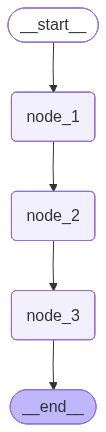

In [11]:
# ============================================================================
# BUILD A MULTI-NODE GRAPH
# ============================================================================

# Create a new graph builder
builder = StateGraph(State)

# Add all three nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", final_node)

# Define the execution flow: START → node_1 → node_2 → node_3 → END
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# Compile the graph
graph = builder.compile()

# Visualize the multi-node graph
print("Multi-Node Graph Structure:")
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# ============================================================================
# EXECUTE THE MULTI-NODE GRAPH
# ============================================================================
# Watch the output - notice how the original input gets LOST!

print("=" * 60)
print("PROBLEM: State gets OVERWRITTEN in each node")
print("=" * 60)

result = graph.invoke({"messages": "Hi, how are you?."})

print("=" * 60)
print(f"Final result: {result}")
print("=" * 60)
print("\n⚠️ ISSUE: The original input 'Hi, how are you?' is LOST!")
print("   Only the last node's output is preserved.")

PROBLEM: State gets OVERWRITTEN in each node
---Node 1---
  Input: Hi, how are you?.
---Node 2---
  Input: Hello this is node 1
---Node 3---
  Input: Hello this is node 2
Final result: {'messages': 'Hello this is the final node'}

⚠️ ISSUE: The original input 'Hi, how are you?' is LOST!
   Only the last node's output is preserved.


### The Problem with Overwriting State

The state gets overwritten each time in each node which is something which we do not want. We want the agent to be aware of what is happening in each node and store all the intermediate messages also.

**Real-world impact:**
- In a chatbot, we'd lose the conversation history!
- Tool call results would be overwritten by subsequent LLM responses
- We couldn't track what happened at each step

> **Solution**: Use **Reducer Functions** to control how state updates are merged

---

## Part 4: Using Reducer Functions (The Solution!)

### What are Reducers?
A **reducer** is a function that defines **how to merge** new state values with existing ones. Instead of simply overwriting, reducers can:
- **Append** new items to a list
- **Merge** dictionaries
- **Combine** values in custom ways

### The `add_messages` Reducer
LangGraph provides `add_messages` - a built-in reducer that **appends** messages to a list instead of overwriting. This is perfect for:
- Maintaining conversation history
- Tracking tool call sequences
- Preserving the full context

### Syntax: Using `Annotated` with Reducers
```python
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Annotated[type, reducer_function]
    messages: Annotated[list, add_messages]
```

Now let's build the same graph with **reducers** to preserve all messages!

Graph with Reducer-Enabled State:


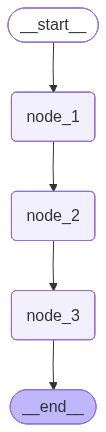

In [13]:
# ============================================================================
# STATE WITH REDUCER FUNCTION
# ============================================================================
# The key difference: Annotated[list, add_messages]
# This tells LangGraph to APPEND messages instead of overwriting

from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State with a reducer function for messages.
    
    The Annotated type hint does two things:
    1. Declares 'messages' as type 'list'
    2. Attaches 'add_messages' as the reducer function
    
    Now when a node returns {"messages": "..."}, it will be APPENDED
    to the existing list, not overwrite it!
    """
    messages: Annotated[list, add_messages]  # ← The magic happens here!

# -----------------------------------------------------------------------------
# Updated nodes - same logic, but now state will accumulate
# -----------------------------------------------------------------------------
def node_1(state: State) -> State:
    """Node 1 - notice how we can see the growing state"""
    print("---Node 1---")
    print(f"  Current messages count: {len(state['messages'])}")
    print(f"  Current state: {[m.content if hasattr(m, 'content') else m for m in state['messages']]}")
    return {"messages": "Hello this is node 1"}  # This will be APPENDED!

def node_2(state):
    """Node 2 - state now includes node_1's output"""
    print("---Node 2---")
    print(f"  Current messages count: {len(state['messages'])}")
    print(f"  Current state: {[m.content if hasattr(m, 'content') else m for m in state['messages']]}")
    return {"messages": "Hello this is node 2"}  # This will be APPENDED!

def final_node(state):
    """Node 3 - state includes all previous outputs"""
    print("---Node 3---")
    print(f"  Current messages count: {len(state['messages'])}")
    print(f"  Current state: {[m.content if hasattr(m, 'content') else m for m in state['messages']]}")
    return {"messages": "Hello this is the final node"}  # This will be APPENDED!

# Build the graph (same structure as before)
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", final_node)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

graph = builder.compile()

# View the graph
print("Graph with Reducer-Enabled State:")
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# ============================================================================
# EXECUTE THE GRAPH WITH REDUCER - ALL MESSAGES PRESERVED!
# ============================================================================

print("=" * 70)
print("SOLUTION: Using add_messages reducer - ALL messages are preserved!")
print("=" * 70)

response = graph.invoke({"messages": "Hi, how are you?."})

print("=" * 70)
print("\nFinal response structure:")
print(f"  Total messages: {len(response['messages'])}")
print("\nAll messages preserved:")
for i, msg in enumerate(response['messages']):
    content = msg.content if hasattr(msg, 'content') else msg
    print(f"  [{i}] {content}")

# Show the response
response

SOLUTION: Using add_messages reducer - ALL messages are preserved!
---Node 1---
  Current messages count: 1
  Current state: ['Hi, how are you?.']
---Node 2---
  Current messages count: 2
  Current state: ['Hi, how are you?.', 'Hello this is node 1']
---Node 3---
  Current messages count: 3
  Current state: ['Hi, how are you?.', 'Hello this is node 1', 'Hello this is node 2']

Final response structure:
  Total messages: 4

All messages preserved:
  [0] Hi, how are you?.
  [1] Hello this is node 1
  [2] Hello this is node 2
  [3] Hello this is the final node


{'messages': [HumanMessage(content='Hi, how are you?.', additional_kwargs={}, response_metadata={}, id='5b9be95b-c944-40e8-810d-2494d6730f7a'),
  HumanMessage(content='Hello this is node 1', additional_kwargs={}, response_metadata={}, id='bcd01ba7-918a-4cf2-a1f1-565fa6a9fa29'),
  HumanMessage(content='Hello this is node 2', additional_kwargs={}, response_metadata={}, id='e2f7c8d0-3f48-4f2c-95aa-32f42b15bb8c'),
  HumanMessage(content='Hello this is the final node', additional_kwargs={}, response_metadata={}, id='1110cd3b-6b09-44c9-8f47-cdd5f4757450')]}

In [15]:
# ============================================================================
# ACCESSING THE LAST MESSAGE
# ============================================================================
# In agentic systems, you often want the LAST message (the final response)
# But you can access ANY message in the history!

print("Accessing the last message (most recent response):")
print("-" * 50)

last_message = response['messages'][-1]
print(f"Type: {type(last_message).__name__}")
print(f"Content: {last_message.content if hasattr(last_message, 'content') else last_message}")

# You can also access the first message (original input)
print("\nFirst message (original input):")
first_message = response['messages'][0]
print(f"Content: {first_message.content if hasattr(first_message, 'content') else first_message}")

Accessing the last message (most recent response):
--------------------------------------------------
Type: HumanMessage
Content: Hello this is the final node

First message (original input):
Content: Hi, how are you?.


---

## Summary: Key Takeaways

### What We Learned

1. **State is the heart of LangGraph** - It's the shared data structure that flows through all nodes
2. **Nodes are Python functions** - They read from state, process, and return updates
3. **Edges define flow** - They connect nodes and determine execution order
4. **Default behavior overwrites** - Without reducers, new values replace old ones
5. **Reducers preserve history** - `add_messages` appends instead of overwriting

### Important Patterns

| Pattern | When to Use |
|---------|-------------|
| Simple State (str, int) | Single-value tracking, counters |
| List with `add_messages` | Conversation history, message chains |
| Custom TypedDict | Complex applications with multiple fields |

### Common Pitfalls to Avoid

- **Forgetting reducers** - Results in lost conversation history
- **Not using TypedDict** - Loses type safety and documentation
- **Overcomplicating state** - Start simple, add fields as needed

### Next Steps
In the next notebook, we'll learn about **Conditional Routing** - how to dynamically choose which node to execute based on the current state!